# Analiza nepremičnin na trgu
(Projektna naloga pri predmetu Uvod v programiranje)

Avtor: Tinej Lampič

Podatki so bili zajeti dne 6. 9. 2025 iz spletnega oglasnika Bolha (spletni naslov: https://www.bolha.com/nepremicnine). 



In [381]:
import pandas as pd      
import numpy as np 
import matplotlib.pyplot as plt  
import seaborn as sns    
import ipyleaflet as Map      

pd.set_option("display.max_rows", 10)  #vedno se izpiše le 10 vrstic
%matplotlib inline

NEPREMICNINE = pd.read_csv("podatki/nepremicnine.csv", index_col=False)
NEPREMICNINE['id oglasa'] = range(1, len(NEPREMICNINE) + 1)
NEPREMICNINE = NEPREMICNINE[["id oglasa", "lokacija", "povrsina", "cena", "razdalja", "datum"]]    #id oglasa je v prvi koloni
     
NEPREMICNINE

,id oglasa,lokacija,povrsina,cena,razdalja,datum
0,1,"Primorsko-goranska, Rijeka",68.74 m2,305.000 €,77.38 km,04.09.2025
1,2,"Primorsko-goranska, Opatija",121.35 m2,725.000 €,79.51 km,13.08.2025
2,3,"Moravče, Moravče",300 m2,350.000 €,22.46 km,18.06.2025
3,4,"Ljubljana Šiška, Spodnja Šiška",187.25 m2,548.200 €,2.28 km,08.04.2025
4,5,"Vrhnika, Sinja Gorica",111.3 m2,298.000 €,15.67 km,22.08.2024
...,...,...,...,...,...,...
4176,4177,"Prebold, Šešče pri Preboldu",370 m2,480.000 €,53.56 km,14.05.2020
4177,4178,"Radovljica, Radovljica",1 m2,Cena po dogovoru,41.06 km,05.09.2019
4178,4179,"Tržič, Tržič",1 m2,Cena po dogovoru,37.98 km,03.09.2019
4179,4180,"Zreče, Zreče",72.6 m2,140.000 €,79.78 km,14.11.2017


Za začetek si oglejmo kakšne so cene nepremičnin na $m^2$.

In [382]:
def cena_to_float(cena):
    try:
        return float(cena.replace('€','').replace('.','').replace(' ','')) 
    except:
        return np.nan  # če ni številka, se izpiše Nan

cena_nova = NEPREMICNINE["cena"].apply(cena_to_float)
povrsina_nova= NEPREMICNINE["povrsina"].str.replace(',','.').str.replace(' m2','').astype(float)
cena_na_m2 = cena_nova / povrsina_nova
cena_na_m2 = cena_na_m2.apply(lambda x: f"{x:.2f} €/m2" if pd.notna(x) else np.nan)

NEPREMICNINE["cena na m2"] = cena_na_m2
NEPREMICNINE[["id oglasa", "povrsina", "cena", "cena na m2"]]


,id oglasa,povrsina,cena,cena na m2
0,1,68.74 m2,305.000 €,4437.01 €/m2
1,2,121.35 m2,725.000 €,5974.45 €/m2
2,3,300 m2,350.000 €,1166.67 €/m2
3,4,187.25 m2,548.200 €,2927.64 €/m2
4,5,111.3 m2,298.000 €,2677.45 €/m2
...,...,...,...,...
4176,4177,370 m2,480.000 €,1297.30 €/m2
4177,4178,1 m2,Cena po dogovoru,NaN
4178,4179,1 m2,Cena po dogovoru,NaN
4179,4180,72.6 m2,140.000 €,1928.37 €/m2


Spodnja tabela prikazuje, v katerih krajih so nepremičnine najdražje in v katerih najcenejše glede na ceno na kvadratni meter ( € / $m^2$ ), razvrščeno od najdražjih do najcenejših.

In [383]:
NEPREMICNINE['cena_na_m2_num'] = NEPREMICNINE['cena na m2'].str.replace(' €/m2','').astype(float)    #pretvori v float
NEPREMICNINE_sorted = NEPREMICNINE.sort_values(by='cena_na_m2_num', ascending=False).reset_index(drop=True)    #da gre pandasov index od 0 naprej
NEPREMICNINE_sorted[["id oglasa", "lokacija", "cena na m2"]].head(10)
                                                                          #zemljevid z lokacijami najdražjih?

,id oglasa,lokacija,cena na m2
0,2454,"Ljubljana Šiška, Šiška",21212.12 €/m2
1,2763,"Primorsko-goranska, Opatija - Okolica",21000.00 €/m2
2,2503,"Ljubljana Center, Center",20903.01 €/m2
3,3582,"Piran, Portorož",16137.23 €/m2
4,3559,"Istrska, Buzet",15841.58 €/m2
5,1360,"Piran, Piran",15714.29 €/m2
6,2614,"Ljubljana Center, Stara Ljubljana",14357.05 €/m2
7,2695,"Primorsko-goranska, Opatija",13425.93 €/m2
8,3479,"Primorsko-goranska, Lovran",13297.87 €/m2
9,1571,"Istrska, Buzet",12668.25 €/m2


Prav gotovo izstopajo večja mesta, taka je seveda Ljubljana, sledijo pa ji obmorska mesta na slovenski in hrvaški obali. Prav na hrvaško obalo pa v času poletnih počitnic verjetno najraje zahajamo slovenski turisti. Preverimo, kako so se spreminjale povprečne cena za $m^2$ nepremičnine na hrvaški obali v zadnjih petih sezonah.

In [384]:
NEPREMICNINE['regija'] = NEPREMICNINE['lokacija'].str.split(',').str[0]
NEPREMICNINE_regija = NEPREMICNINE[NEPREMICNINE['regija'] == 'Primorsko-goranska'].copy()
NEPREMICNINE_regija['datum'] = pd.to_datetime(NEPREMICNINE_regija['datum'], dayfirst=True, errors='coerce')
NEPREMICNINE_regija['leto'] = NEPREMICNINE_regija['datum'].dt.year
povprecna_cena_m2_po_letih = NEPREMICNINE_regija.groupby('leto')['cena_na_m2_num'].mean().round(2)
povprecna_cena_m2_po_letih



leto
2021    2138.79
2022     313.20
2023    2936.48
2024    3320.88
2025    3623.81
Name: cena_na_m2_num, dtype: float64

Opazimo, da cena vztrajno narašča, hrvaški nepremičninski trg je velik padec doživel le leta 2022, kar seveda lahko pripišemo manjšemu obsegu povpraševanja zaradi epidemije koronavirusa. Padec in nato ponoven sunkovit skok cen lahko prikažemo tudi na diagramu.

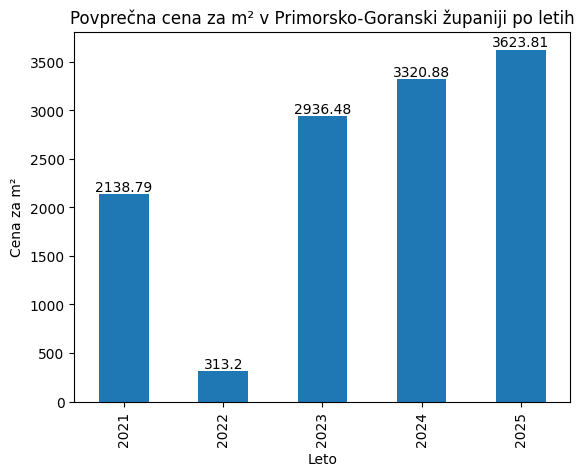

In [385]:
ax = povprecna_cena_m2_po_letih.plot(kind='bar')
plt.ylabel("Cena za m²")
plt.xlabel("Leto")
plt.title("Povprečna cena za m² v Primorsko-Goranski županiji po letih")
for i, v in enumerate(povprecna_cena_m2_po_letih):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom')
plt.show()